<a href="https://colab.research.google.com/github/ali7amie/Tianlai-M2-Internship-/blob/master/source_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ali7amie/Tianlai-M2-Internship-.git
%cd /content/Tianlai-M2-Internship-/
!ls

!pip install photutils
!pip install healpy
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image
import scipy.ndimage as nd
import numpy.ma as ma
import pandas as pd

fatal: destination path 'Tianlai-M2-Internship-' already exists and is not an empty directory.
/content/Tianlai-M2-Internship-
abstract.pdf					 nvss_src_S1000_dec80.txt
a.py						 pixel2world.py
compute_barycenter.py				 ploting_test.py
compute_flux.py					 post_processing.py
convert_map_index.py				 post_process.py
create_gaussian_src.py				 __pycache__
create_map.py					 pythmaps-fdr.py
create_skymaps_efficiency.csh			 README.md
create_skymaps_fdr.csh				 realcom.py
cross_matching.py				 skymaps-fdr.py
detection_kernels.py				 sort_signal_to_noise.py
estimation.py					 source_finder.ipynb
extract_class.py				 src_finder.py
filtmap_ncp_autoon_0.001_1300_0.075_0_4dec.fits  src_generator.py
global_bg_estimation.py				 srcgennvss.py
haslam1300eq.fits				 srcgen.py
hierarchical_merging.py				 sub.csh
k2jansky.py					 test.csh
maps.py						 Tianlai-M2-Internship-
nvss.py						 upper2center.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple

# Introduction

# Simulating sky maps

## Simulating with Python

Simulate a gaussian source 

In [ ]:
import k2jansky

def create_gaussian_src(src_size,src_std,src_flux_jansky):
    # create a source with amplitude of 1 k
    x,y = np.meshgrid(np.linspace(-(src_size//2),src_size//2,src_size),np.linspace(-(src_size//2),src_size//2,src_size))
    mean_x=0
    mean_y=0
    src=np.exp(-(x-mean_x)**2/(2*src_std**2)) * np.exp(-(y-mean_y)**2/(2*src_std**2))
    flux_kelvin_of_1k_amplitude=np.sum(src)
    flux_jansky_of_1k_amplitude=k2jansky.k2jansky('freq',1300*10**6,16.5,1,flux_kelvin_of_1k_amplitude)
    # add the src_flux_jansky factor
    src=(src_flux_jansky/flux_jansky_of_1k_amplitude)*np.exp(-(x-mean_x)**2/(2*src_std**2)) * np.exp(-(y-mean_y)**2/(2*src_std**2))
    return src

d=create_gaussian_src(5,1.1,1)



    

Simulate a map

In [ ]:


import create_gaussian_src



def create_map(map_size,src_number,src_size,src_std,src_flux_jansky,noise_std):
    """ This function create a map as a 2D Numpy array, enter map_size,src_number,src_size,src_std,src_flux_jansky,noise_std"""

    #create empty map
    rectmap=np.zeros((map_size,map_size))

    #create a gaussian source
    src=create_gaussian_src.create_gaussian_src(src_size,src_std,src_flux_jansky)

    #add src_number source to with random position, but with 2*src_size distant from the boundary.
    x=np.random.random_integers(low=2*src_size,high=map_size-2*src_size,size=src_number)
    y=np.random.random_integers(low=2*src_size,high=map_size-2*src_size,size=src_number) #generate random position, note that x and y here represent a matrix like coordinate, so the number of column or absice is y, the number of row or ordonnée is x
    
    for i in range(0,len(x)):
            rectmap[y[i]-(src_size//2):y[i]+((src_size//2)+1),x[i]-(src_size//2):x[i]+((src_size//2)+1)]=src
    
    #add gaussian noise
    noise =  make_noise_image((map_size,map_size), distribution='gaussian', mean=0,stddev=noise_std)
    rectmap=rectmap+noise
    catalog=np.transpose((y,x,src_flux_jansky*np.ones_like(x)))#upper pix_center, pix center to index. pix corner ??? plot??    
    return (rectmap,catalog)

simulation=create_map(50,10,5,1.1,1,0.001)  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead


## Map making with JSKyMap software

# Source finder

## Detailed notebook description

### Input map

#### Maps made with JSKyMap

This program take a map to give source catalog. Two kinds of input are used. The standard kind consist of spherical full sky map in fits format and healpix pixelization. The other kind is a practical solution while developing the algorithm, in this case the input consist of numpy array.

<br>

**First step** <br> 
Take the fits file <br> convert it to numpy array of spherical map healpix pixel (with healpy) <br> crop a projection of NCP and put it in a numpy array of rectangular map pixels




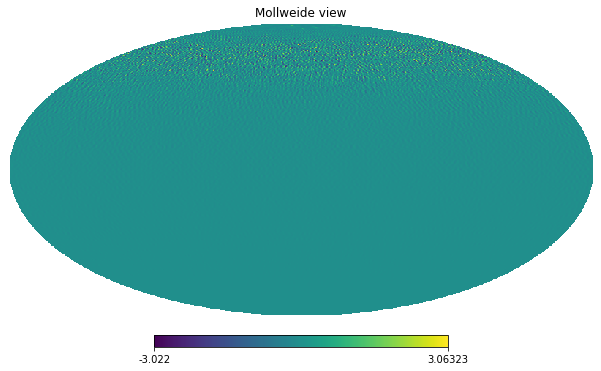

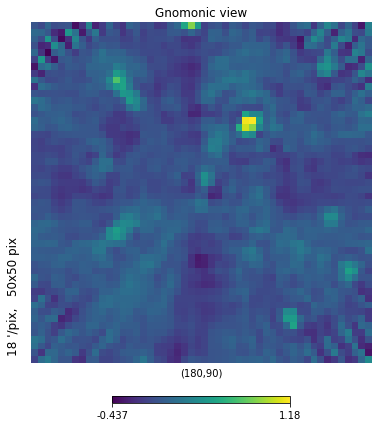

In [ ]:

def fits2map(fits_filename,map_size, map_resolution, projection_center):

  ''' This function take a fits file, convert it into full spherical sky map,
   and return a gnomonic projection around a given point 

   fits_filename : str
                   FITS file name

   map_size : int
              the side length in pixels of of the square gnomonic map

   map_resolution : int
                    map resolution in arcminutes

   projection_center : tuple
                       (longitude, latitude) the coordinate of the projection center in degrees '''

  #convert the fits file into healpix pixelized full sky map
  full_map = hp.read_map(fits_filename,dtype = None)

  #display a mollweide projection
  spherical_map = hp.mollview(full_map,return_projected_map = True)#, no_plot = True)

  #crop a gnomonic view at NCP
  rectmap = hp.gnomview(full_map,rot=[projection_center[0],projection_center[1]],reso = map_resolution,xsize = map_size,ysize = map_size,return_projected_map = True)#, no_plot = True)
  

  return (rectmap,[0,0])

JS_simulation = fits2map("filtmap_ncp_autoon_0.001_1300_0.075_0_4dec.fits",50,18,(180,90))



#### Maps made with python

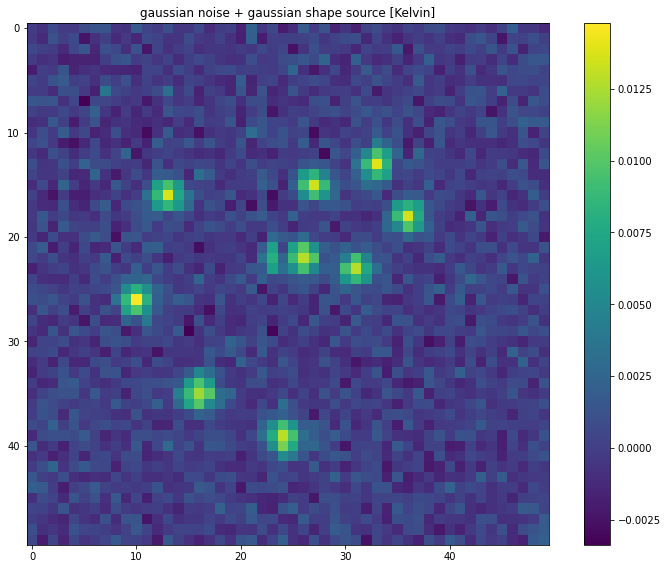

,vertical coor[pixel],horizontal coor[pixel],flux[Jy]
0,22,24,1
1,13,33,1
2,35,16,1
3,16,13,1
4,18,36,1
5,23,31,1
6,22,26,1
7,26,10,1
8,39,24,1
9,15,27,1


In [ ]:
rectmap=simulation[0]
simulated_catalog=simulation[1]

plt.figure(figsize=[12.8, 9.6])
plt.imshow(rectmap)
plt.colorbar()
plt.title('gaussian noise + gaussian shape source [Kelvin]')
plt.show()


simulation_dataframe=pd.DataFrame(simulated_catalog,columns=['vertical coor[pixel]','horizontal coor[pixel]','flux[Jy]'])
simulation_dataframe

**Second step** <br> Now, we the map is a numpy array. We execute the src finder on it <br> Global background estimation <br> Execute the detection criteria equation <br> if no detection give ????? <br> else <br> sort by signal to noise <br> hierarchical merging <br> compute barycenter <br> give a final data frame

### Global background estimation

In [ ]:
def rectmap_statistics(rectmap):
    return(np.median(rectmap),np.std(rectmap))


Creating the kernels and detection tools before execute the detection criteria
<br>
we used three kernels : cental, intermediate, and peripheric <br> (**could be made with open CV???**)

### Detection kernels

In [ ]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 1)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


def create_kernels(detection_kernels_size):


    ''' This function take the size of kernels and give the kernels 

    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel) '''


    #create the central kernel
    normalization1 = 1/detection_kernels_size[0]**2
    central_kernel = normalization1 * np.ones((detection_kernels_size[0],detection_kernels_size[0]))

    #create intermediate kernel
    normalization2 = 1/(detection_kernels_size[1]**2 - detection_kernels_size[0]**2)
    intermediate_kernel = normalization2 * np.pad(0*central_detection_kernel,int((detection_kernels_size[1]-detection_kernels_size[0])/2),pad_with)

    #create peripherical kernel
    normalization3 = 1/(detection_kernels_size[2]**2 - detection_kernels_size[1]**2)
    peripherical_kernel = normalization3 * np.pad(0*intermediate_detection_kernel,int((detection_kernels_size[2]-detection_kernels_size[1])/2),pad_with)

    
    
    
    return (central_kernel, intermediate_kernel, peripherical_kernel)

kernels=create_kernels((3,5,7))




In [ ]:
def create_conv_maps(kernels,detection_kernels_size,rectmap):


    ''' This function take three kernels and give convolution maps 

    kernels: tuple
             (central kernel (ndarray), intermediate kernel (ndarray), peripherical kernel (ndarray))
             
    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel) '''

    central_kernel_map=nd.convolve(rectmap,kernels[0])
    intermediate_kernel_map=nd.convolve(rectmap,kernels[1])
    peripherical_kernel_map=nd.convolve(rectmap,kernels[2])


    # an additional kernel wich compute median and std maps (local background)   
    peripheric_median_map=np.zeros_like(rectmap)
    peripheric_std_map = np.zeros_like(rectmap)
    mask=np.array(kernels[2]==0)
    for i in range(int(detection_kernels_size[2]/2),rectmap.shape[0]-int(detection_kernels_size[2]/2)):
        for j in range(int(detection_kernels_size[2]/2),rectmap.shape[1]-int(detection_kernels_size[2]/2)):
            if (detection_kernels_size[2]/2).is_integer()==False:
                kernel=rectmap[i-int(detection_kernels_size[2]/2):i+(int(detection_kernels_size[2]/2)+1),j-int(detection_kernels_size[2]/2):j+(int(detection_kernels_size[2]/2)+1)]
                    
            else:
                    
                kernel=rectmap[i-int(detection_kernels_size[2]/2):i+int(detection_kernels_size[2]/2),j-int(detection_kernels_size[2]/2):j+int(detection_kernels_size[2]/2)]
                    
            masked_kernel=ma.masked_array(kernel,mask)
            peripheric_std_map[i][j]=np.ma.std(masked_kernel)
            peripheric_median_map[i][j]=np.ma.median(masked_kernel)

    return (central_kernel_map,intermediate_kernel_map,peripherical_kernel_map,peripheric_median_map,peripheric_std_map)       

conv_maps=create_conv_maps(kernels,detection_kernels_size,rectmap)

plt.figure(figsize=[35.6, 19.2])
title=['avg central kernel','avg intermediate kernel','avg peripherical kernel','median peripherical kernel','std peripherical kernel']
for i in range(0,len(conv_maps)):
   
    plt.subplot(231+i)
    plt.imshow(conv_maps[i])
    plt.title(title[i])
    plt.colorbar()

plt.subplot(231+i+1)
plt.imshow(rectmap)
plt.title('original') 
plt.colorbar()   

plt.show()


Now we have the detection kernels <br> we conduct a detection criteria: a pixels belong to a potential source if: avg(central_kernel)>local_bg+n*local_std

### Detection condition equation

In [ ]:
def detection(conv_maps,n):

     ''' This function take convolution maps, manipulate them within detection criteria, 
     and return list of pixels that belong to potential sources and their amplitude. It is sorted by the S/N ratio

    conv_maps: tuple
               (avg central map (ndarray), avg intermediate map (ndarray), avg peripherical map (ndarray), median peripherical map (ndarray), std peripherical map (ndarray))
             
    n: int
       The detection threshold '''


     threshold = conv_maps[3] + n * global_std 
     first_condition = conv_maps[0] >= threshold 
     detected_src_coor_upper_pixcorner = np.where( first_condition )  #this list of coordinate are in the upper system (vertical from top, horizontal from left) and each pixel is localized by its corner
     signal = rectmap[detected_src_coor_upper_pixcorner]
     local_bg = conv_maps[3][detected_src_coor_upper_pixcorner] 
     signal_to_noise = signal/local_bg
     raw_detected_pix=np.column_stack((detected_src_coor_upper_pixcorner[0],detected_src_coor_upper_pixcorner[1],signal,local_bg,signal_to_noise))
     raw_detection = pd.DataFrame(raw_detected_pix,columns=['vertical coor','horizontal coor','Amplitude [K]','Local bg','S/N'])
     sorter=np.flip(np.argsort(raw_detection['S/N']))
     sorted_raw_detection = raw_detection.iloc[sorter]
     return sorted_raw_detection

sorted_raw_detection = detection(conv_maps,1)
sorted_raw_detection





Now we have a list of pixels that are said to belong to potential sources. We should sort these pixels into sources. We sort pixels by their S/N ratio, and then merge them hierarchicaly. We set a threshold of temperature, and assign other pixels inside an aperture to the targeted one.<br>
Sorting by signal to noise

### Sorting by signal to noise

### Hierarchical merging

In [ ]:
aperture=(2.5,3)
table = sorted_signal_to_noise_and_coor_list
all_agglomerations_index=[]
for i in range(0,len(table[:,0])):
    if table[:,5][i]==0:
        pixels_index_in_each_src=[]
        for j in range(0,len(table[:,0])):
            if ( table[:,3][j] >= table[:,3][i]-aperture[0] ) and ( table[:,3][j] <= table[:,3][i]+aperture[0] ) and  ( table[:,4][j] >= table[:,4][i]-aperture[0] ) and ( table[:,4][j] <= table[:,4][i]+aperture[0] ):
                offset=np.sqrt( ( table[:,3][i] - table[:,3][j] )**2 + (table[:,4][i] - table[:,4][j])**2 )
                if offset<=aperture[1]:
                    pixels_index_in_each_src.append(int(table[:,0][j]))
                    table[:,5][j]=1
        all_agglomerations_index.append(pixels_index_in_each_src)
all_agglomerations_index

### Compute barycenters

In [ ]:
all_agglomerations=np.transpose(( np.arange(0,len(all_agglomerations_index)), all_agglomerations_index))  
x_barycenter_list=[]
y_barycenter_list=[]
for i in range(0,len(all_agglomerations[:,1])):
    x_barycenter=np.sum(signal_to_noise_and_coor_list[:,4][all_agglomerations[:,1][i]]*signal_to_noise_and_coor_list[:,1][all_agglomerations[:,1][i]])/np.sum(signal_to_noise_and_coor_list[:,1][all_agglomerations[:,1][i]])
    y_barycenter=np.sum(signal_to_noise_and_coor_list[:,3][all_agglomerations[:,1][i]]*signal_to_noise_and_coor_list[:,1][all_agglomerations[:,1][i]])/np.sum(signal_to_noise_and_coor_list[:,1][all_agglomerations[:,1][i]])
    x_barycenter_list.append(x_barycenter)
    y_barycenter_list.append(y_barycenter)

barycenter_list=np.transpose((np.round(y_barycenter_list,1).astype(int),np.round(x_barycenter_list,1).astype(int) ))


### Computing fluxes

In [ ]:
flux_integration_kernel=np.ones((detection_kernels_size[2],detection_kernels_size[2]))
flux_map=nd.convolve(rectmap,flux_integration_kernel)-(detection_kernels_size[2]**2)*peripheric_median_map  # what to do with negative median - use farer and thiner ring
#coor=np.transpose((barycenter_list[0],barycenter_list[1]))
coor=( barycenter_list[:,1] , barycenter_list[:,0] )
flux_list_k=flux_map[coor]
flux_list_jansky=k2jansky.k2jansky('freq',1300*10**6,16.5,1,flux_list_k)


flux_list=(flux_list_k,flux_list_jansky)
     

### Three cartesian coordinate system

In [ ]:
import convert_map_index

simulated_coor_center=convert_map_index.convert_upper_to_center( [ simulated_catalog[:,0],simulated_catalog[:,1] ] , np.shape(rectmap)[0],len(simulated_catalog[:,0]) )[4]
coor_center=convert_map_index.convert_upper_to_center(detected_src_coor_upper_pixcorner,np.shape(rectmap)[0],len(detected_src_coor_upper_pixcorner[0]))[4]
bar_center=convert_map_index.convert_upper_to_center([barycenter_list[:,1],barycenter_list[:,0]],np.shape(rectmap)[0],len(barycenter_list[0]))[4]



### World coordinate

In [ ]:
import pixel2world
projection_center=(90,180)
map_resolution=18

barycenter_list_world=pixel2world.pixel2world(projection_center,map_resolution,bar_center)
simulated_src_world=pixel2world.pixel2world(projection_center,map_resolution,simulated_coor_center)


### Detected sources catalog

In [ ]:
final_catalog=np.transpose((barycenter_list_world[:,0],barycenter_list_world[:,1],flux_list[1]))
dd=np.argsort(final_catalog[:,0])
final_catalog=final_catalog[dd]
final_catalog=np.column_stack( ( range(0,len(final_catalog)) , final_catalog ))

import pandas as pd

detection_dataframe=pd.DataFrame(final_catalog,columns=['index','dec[deg]','ra[deg]','flux[Jy]'])
detection_dataframe


### Simulated sources catalog

In [ ]:
simulated_final_catalog=np.transpose((simulated_src_world[:,0],simulated_src_world[:,1],simulated_catalog[:,2]))
ff=np.argsort(simulated_final_catalog[:,0])
simulated_final_catalog=simulated_final_catalog[ff]
simulated_final_catalog=np.column_stack( ( range(0,len(simulated_final_catalog)) , simulated_final_catalog ))

simulated_final_catalog

simulation_dataframe=pd.DataFrame(simulated_final_catalog,columns=['index','dec[deg]','ra[deg]','flux[Jy]'])
simulation_dataframe


Plot

In [ ]:
 import ploting_test
 ploting_test.ploting_test(rectmap,coor_center,bar_center,simulated_coor_center)

## Object oriented version